In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

ratings = pd.read_csv('/content/drive/MyDrive/국민체력 100 빅데이터활용 공모전/ratings.csv')
ratings

,user_id,exercise,rating
0,0,상지 루틴 스트레칭,3
1,0,유산소 운동 전 동적 루틴 스트레칭,4
2,0,등/어깨 뒤쪽 스트레칭,5
3,0,팔굽혀 펴기,1
4,0,윗몸올리기,2
...,...,...,...
5035,144,양팔 벌려 전신 비틀기,2
5036,144,깍지 끼고 상체 숙이기,3
5037,144,어깨 스트레칭,4
5038,144,수영,5


In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
ratings['exercise'] = encoder.fit_transform(ratings['exercise'].values)
ratings

,user_id,exercise,rating
4761,147,346,4
4892,158,4,2
4217,138,143,4
438,17,147,2
2520,89,235,3
...,...,...,...
2323,79,342,3
185,2,358,1
1701,62,233,4
1695,58,2,1


In [ ]:
display(encoder.classes_)

array(['V자 싸이클', '가슴 스트레칭', '가슴 어깨 펴기', '가슴/어깨 스트레칭', '가슴/어깨 앞쪽 스트레칭',
       '걷기', '겨드랑이 늘리기', '결가부좌', '계단 두 칸씩 뛰기', '계단 두발 뛰기', '계단 뛰어 오르기',
       '계단 올라갔다 내려오기', '계단 한발 뛰기', '고양이 자세', '고정식 자전거 타기',
       '고정식 트레드밀에서 걷기', '고혈압환자_순환식 근력운동 프로그램', '고혈압환자_심폐지구력운동',
       '골다공증을 위한 근력운동1', '골다공증을 위한 스트레칭', '골다공증을 위한 심폐지구력 운동', '골반 스트레칭',
       '골반 스트레칭2', '공 잡고 들어올리기', '공에 엎드려서 상체 들어올리기', '관절염을 위한 근력운동1',
       '관절염을 위한 근력운동2', '관절염을 위한 스트레칭', '굽힘 밸런스운동-60~120도 사이', '균형 걷기',
       '깍지 끼고 상체 숙이기', '깍지끼고 목 들어올리기', '나란히 서서 손잡고 끌어당기기', '나무자세',
       '내전근 스트레칭', '넙다리 뒤쪽 스트레칭', '넙다리 안쪽 스트레칭', '네발 걷기',
       '네발기기 자세로 팔 다리 들기', '네발기기 자세에서 다리 위로 뻗어올리기',
       '네발기기 자세에서 손바닥으로 바닥밀기', '누워 다리 들어올리기', '누워 무릎 교차 올리기', '누워 무릎 기울기',
       '누워 발목 당겨주기', '누워서 다리 굽히기', '누워서 다리 들어올리기', '누워서 다리 좌우로 움직이기',
       '누워서 덤벨 들어올리기', '누워서 막대 잡고 팔 회전하기', '누워서 밀기', '누워서 배가로근 수축 I',
       '누워서 배가로근 수축 II', '누워서 엉덩이 들어올리기', '누워서 전신 뻗기',
       '누워서 팔 다리 동시에 들어올리기', '누워서 팔 밀기', '누워서 하늘 자전거', '다리 감아올리기',
    

In [ ]:
# train test 분리
from sklearn.utils import shuffle
TRAIN_SIZE = 0.8
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [ ]:
ratings_train

,user_id,exercise,rating
762,26,160,4
2625,92,229,2
789,27,267,2
1129,41,286,3
4602,160,134,1
...,...,...,...
370,11,287,3
2603,73,57,5
2452,86,96,3
1216,24,339,4


In [ ]:
ratings_test

,user_id,exercise,rating
1338,47,160,2
3397,118,94,4
177,15,267,4
2711,94,54,3
3158,112,298,3
...,...,...,...
1933,69,132,1
2292,80,99,1
3617,123,64,1
3462,119,44,3


In [ ]:
##### (1)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, Adamax

# Variable 초기화 
K = 150                            # Latent factor 수 
mu = ratings_train.rating.mean()    # 전체 평균 
M = ratings.user_id.max() + 1       # Number of users
N = ratings.exercise.max() + 1      # Number of movies

In [ ]:
# Defining RMSE measure
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [ ]:
# Keras model
user = Input(shape=(1, ))                                               # User input
item = Input(shape=(1, ))                                               # Item input
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)        # (M, 1, K)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)        # (N, 1, K)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)          # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)          # Item bias term (N, 1, )

# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation, Dropout
P_embedding = Flatten()(P_embedding)                                    # (K, )
Q_embedding = Flatten()(Q_embedding)                                    # (K, )
user_bias = Flatten()(user_bias)                                        # (1, )
item_bias = Flatten()(item_bias)                                        # (1, )
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])     # (2K + 2, )

# Neural network
R = Dense(2048)(R)
R = Activation('linear')(R)
R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(1)(R)

model = Model(inputs=[user, item], outputs=R)
model.compile(
  loss=RMSE,
  optimizer=SGD(),
  metrics=[RMSE]
)
model.summary()

# Model fitting
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.exercise.values],
  y=ratings_train.rating.values - mu,
  epochs=100,
  batch_size=256,
  validation_data=(
    [ratings_test.user_id.values, ratings_test.exercise.values],
    ratings_test.rating.values - mu
  )
)

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_44 (Embedding)        (None, 1, 150)       25200       input_23[0][0]                   
__________________________________________________________________________________________________
embedding_45 (Embedding)        (None, 1, 150)       56550       input_24[0][0]                   
___________________________________________________________________________________________

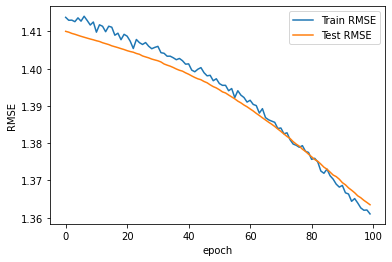

In [ ]:
# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
# Prediction
user_ids = ratings_test.user_id.values[0:6]
exercise = ratings_test.exercise.values[0:6]
predictions = model.predict([user_ids, exercise]) + mu
print("Actuals: \n", ratings_test[0:6])
print()
print("Predictions: \n", predictions)

Actuals: 
       user_id  exercise  rating
1338       47       160       2
3397      118        94       4
177        15       267       4
2711       94        54       3
3158      112       298       3
2766       72       190       4

Predictions: 
 [[3.2159667]
 [3.1255426]
 [2.9811883]
 [2.7290726]
 [2.8414392]
 [3.1716695]]


In [ ]:
# 정확도(RMSE)를 계산하는 함수 
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.exercise.values
y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

1.3638209910673005

In [ ]:
# Keras model
user = Input(shape=(1, ))                                               # User input
item = Input(shape=(1, ))                                               # Item input
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)        # (M, 1, K)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)        # (N, 1, K)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)          # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)          # Item bias term (N, 1, )

# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation, Dropout
P_embedding = Flatten()(P_embedding)                                    # (K, )
Q_embedding = Flatten()(Q_embedding)                                    # (K, )
user_bias = Flatten()(user_bias)                                        # (1, )
item_bias = Flatten()(item_bias)                                        # (1, )
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])     # (2K + 2, )

# Neural network
R = Dense(512)(R)
R = Activation('relu')(R)
R = Dropout(0.5)(R)
R = Dense(128)(R)
R = Activation('relu')(R)
R = Dense(1)(R)

model = Model(inputs=[user, item], outputs=R)
model.compile(
  loss=RMSE,
  optimizer=SGD(),
  #optimizer=Adamax(),
  metrics=[RMSE]
)
model.summary()

# Model fitting
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.exercise.values],
  y=ratings_train.rating.values - mu,
  epochs=100,
  batch_size=512,
  validation_data=(
    [ratings_test.user_id.values, ratings_test.exercise.values],
    ratings_test.rating.values - mu
  )
)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 1, 200)       33600       input_15[0][0]                   
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 1, 200)       75400       input_16[0][0]                   
____________________________________________________________________________________________

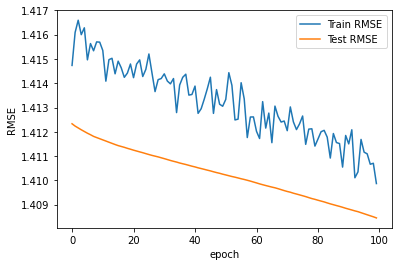

In [ ]:
# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
# 정확도(RMSE)를 계산하는 함수 
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.exercise.values
y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

1.4082943379892632

In [ ]:
# Keras model
user = Input(shape=(1, ))                                               # User input
item = Input(shape=(1, ))                                               # Item input
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)        # (M, 1, K)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)        # (N, 1, K)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)          # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)          # Item bias term (N, 1, )

# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation, Dropout
P_embedding = Flatten()(P_embedding)                                    # (K, )
Q_embedding = Flatten()(Q_embedding)                                    # (K, )
user_bias = Flatten()(user_bias)                                        # (1, )
item_bias = Flatten()(item_bias)                                        # (1, )
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])     # (2K + 2, )

# Neural network
R = Dense(2048)(R)
R = Activation('relu')(R)
R = Dense(1024)(R)
R = Activation('relu')(R)
R = Dense(512)(R)
R = Activation('relu')(R)
R = Dense(128)(R)
R = Activation('relu')(R)
R = Dense(32)(R)
R = Activation('relu')(R)
R = Dense(1)(R)


model = Model(inputs=[user, item], outputs=R)
model.compile(
  loss=RMSE,
  optimizer=SGD(),
  #optimizer=Adamax(),
  metrics=[RMSE]
)
model.summary()

# Model fitting
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.exercise.values],
  y=ratings_train.rating.values - mu,
  epochs=65,
  batch_size=512,
  validation_data=(
    [ratings_test.user_id.values, ratings_test.exercise.values],
    ratings_test.rating.values - mu
  )
)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 1, 200)       33600       input_11[0][0]                   
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 1, 200)       75400       input_12[0][0]                   
____________________________________________________________________________________________

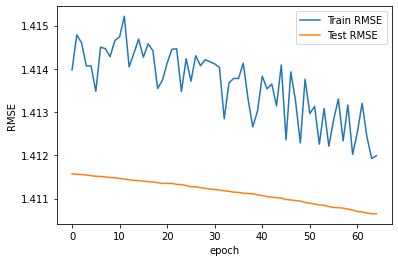

In [ ]:
# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
# 정확도(RMSE)를 계산하는 함수 
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.exercise.values
y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

1.4104778419856523